Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [ ]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# Утилиты для to_categorical()
from tensorflow.keras import utils

# модуль для отсчета времени
import time

In [ ]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

replace /content/bus/Входящий/01009.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


['Входящий', 'Выходящий']

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [ ]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['06394.jpg', '04871.jpg', '05672.jpg', '03022.jpg', '03721.jpg', '00121.jpg', '04106.jpg', '00761.jpg', '03792.jpg', '05150.jpg', '05613.jpg', '03337.jpg', '03096.jpg', '06208.jpg', '00147.jpg', '02399.jpg', '00915.jpg', '04160.jpg', '04727.jpg', '05477.jpg', '02371.jpg', '00076.jpg', '00705.jpg', '05117.jpg', '03989.jpg', '00556.jpg', '05156.jpg', '01507.jpg', '03808.jpg', '03618.jpg', '02589.jpg', '03439.jpg', '04853.jpg', '01431.jpg', '04032.jpg', '04130.jpg', '01187.jpg', '05310.jpg', '01839.jpg', '04886.jpg', '05615.jpg', '03677.jpg', '00662.jpg', '03484.jpg', '04590.jpg', '01302.jpg', '01153.jpg', '00925.jpg', '01673.jpg', '00046.jpg', '00856.jpg', '05377.jpg', '03222.jpg', '06418.jpg', '03156.jpg', '01932.jpg', '03742.jpg', '01564.jpg', '03929.jpg', '05869.jpg', '05179.jpg', '05214.jpg', '04651.jpg', '04173.jpg', '02087.jpg', '01593.jpg', '04248.jpg', '05571.jpg', '04848.jpg', '04877.jpg', '05855.jpg', '03248.jpg', '05168.jpg', '04379.jpg', '01960.jpg', '03343.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

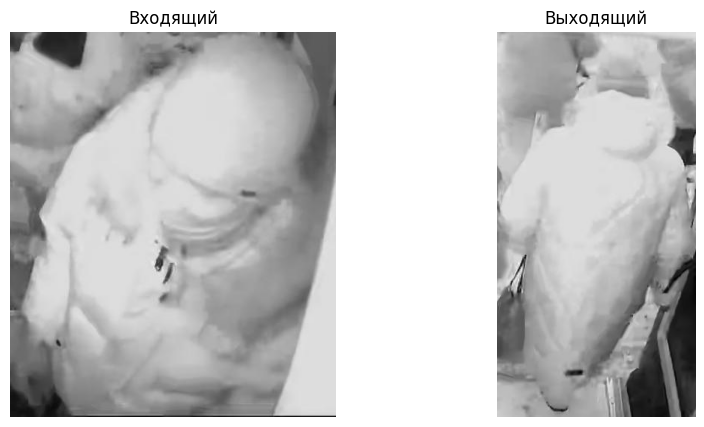

In [ ]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [ ]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [ ]:
data_images = []

for file_name in data_files:
    img = Image.open(file_name).resize((64, 128))
    img_np = np.array(img)
    data_images.append(img_np)

x_data = np.array(data_images)
y_data = np.array(data_labels)

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 9081 фотографий следующей формы: (128, 64, 3)
Общий массив данных изображений следующей формы: (9081, 128, 64, 3)
Общий массив меток классов следующей формы: (9081,)


In [ ]:
x_data = x_data / 255


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size = 0.2,
                                                    shuffle=True,
                                                    random_state=42)

print('Обучающая выборка изображений', len(x_train))
print('Обучающая выборка меток', len(y_train))
print()
print('Тестовая выборка изображений', len(x_test))
print('Тестовая выборка меток', len(y_test))

Обучающая выборка изображений 7264
Обучающая выборка меток 7264

Тестовая выборка изображений 1817
Тестовая выборка меток 1817


In [ ]:
print(y_test[1200])

1


In [ ]:
#y_train = utils.to_categorical(y_train, 2)
#y_test = utils.to_categorical(y_test, 2)

In [ ]:
#print(y_test[56])

[1. 0.]


In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(128, 64, 3)))  # (128,64,3) --> (128,64,256)
model.add(BatchNormalization())  # (128,64,256) --> (128,64,256) й

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))  # (128,64,256) --> (128,64,256)
model.add(MaxPooling2D(pool_size=(3, 3)))  #(128,64,256) --> (42,21,256)

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))  # (42,21,256) --> (42,21,256)
model.add(Dropout(0.2))  # (42,21,256) --> (42,21,256)

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))  # (42,21,256) --> (42,21,512)
model.add(MaxPooling2D(pool_size=(3, 3)))  # (42,21,512) --> (14,7,512)
model.add(Dropout(0.2))  # (14,7,512) --> (14,7,512)

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))  # (14,7,512) --> (14,7,512)
model.add(MaxPooling2D(pool_size=(2, 2)))  # (14,7,512) --> (7,3,512)
model.add(Dropout(0.2))  # (7,3,512) --> (7,3,512)

model.add(Flatten())  # слой преобразования многомерных данных в одномерные (7,3,512) --> (7*3*512) --> (10 752)
model.add(Dense(4096, activation='relu'))  # полносвязный слой, меняется кол-во нейронов (10752) --> (4096)
model.add(Dense(1024, activation='relu'))  # полносвязный слой, меняется кол-во нейронов (4096) --> (1024)
model.add(Dense(32, activation='relu'))  # полносвязный слой, меняется кол-во нейронов (1024) --> (32)
model.add(Dense(1, activation='sigmoid'))  # выходной полносвязный слой, кол-во нейронов = количество классов (32) --> (1)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 64, 256)      7168      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 64, 256)     1024      
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 64, 256)      590080    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 42, 21, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 42, 21, 256)       590080    
                                                                 
 dropout_3 (Dropout)         (None, 42, 21, 256)      

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split = 0.2,
                    verbose=1,
                    shuffle=True)
result = model.evaluate(x_test, y_test)
print(round(result[1] * 100, 2), '%')

Epoch 1/15
46/46 [==============================] - 107s 2s/step - loss: 0.5366 - accuracy: 0.7445 - val_loss: 0.6680 - val_accuracy: 0.7956
Epoch 2/15
46/46 [==============================] - 61s 1s/step - loss: 0.3710 - accuracy: 0.8353 - val_loss: 0.6326 - val_accuracy: 0.8465
Epoch 3/15
46/46 [==============================] - 60s 1s/step - loss: 0.2836 - accuracy: 0.8759 - val_loss: 0.5871 - val_accuracy: 0.8809
Epoch 4/15
46/46 [==============================] - 60s 1s/step - loss: 0.2303 - accuracy: 0.9031 - val_loss: 0.5638 - val_accuracy: 0.9098
Epoch 5/15
46/46 [==============================] - 60s 1s/step - loss: 0.1733 - accuracy: 0.9308 - val_loss: 0.4728 - val_accuracy: 0.9374
Epoch 6/15
46/46 [==============================] - 62s 1s/step - loss: 0.1266 - accuracy: 0.9513 - val_loss: 0.4072 - val_accuracy: 0.9587
Epoch 7/15
46/46 [==============================] - 60s 1s/step - loss: 0.0898 - accuracy: 0.9644 - val_loss: 0.3224 - val_accuracy: 0.9745
Epoch 8/15
46/46 [=